In [1]:
import utils 
import transformer 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import prior 
import transformer2
matplotlib.use('TkAgg')
%matplotlib inline
import main
import importlib
device = torch.device("cuda")
importlib.reload(utils)
importlib.reload(transformer)
importlib.reload(transformer2)
importlib.reload(main)
importlib.reload(prior)
import random
from sklearn.cluster import KMeans
from sklearn.datasets import make_circles
#####################################################################################################################################################
import warnings 
warnings.filterwarnings("ignore")

In [127]:
print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
device = torch.device("cuda")
d_model, nhead, nhid, nlayers = 256, 4, 512, 4
num_epochs = 300
lr = 0.001
num_outputs = 10
seq_len = 200
batch_size = 200
in_features = 2
noise = False
warm_up_epochs = 5
std_variation=True
model = transformer.Transformer(d_model, nhead, nhid, nlayers,in_features=in_features, buckets_size=num_outputs).to(device)
print(f"total params:{sum(p.numel() for p in model.parameters())}")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = utils.get_cosine_schedule_with_warmup(optimizer, warm_up_epochs, num_epochs)
model.criterion = criterion

Using device: Quadro P1000
total params:2114954


In [128]:
%matplotlib inline
model.load_state_dict(torch.load("C:\\Users\\prajb\\OneDrive\\Documents\\TU Delft CSE Masters Y2\\Thesis Projects\\PFN clustering\\models\\saved_model_make_blobs.pt", weights_only=True))
model.eval() 
print("")

In [131]:
%matplotlib inline
temp_batch_size = 10
seq_len= 200
min_classes=5
train_X, train_Y, X_true, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len, num_features=2,min_classes=min_classes, num_classes=10, cluster_type='make_blobs')
batch_classes = batch_classes.permute(1,0)
model.eval()
print("") 

torch.Size([10, 1])



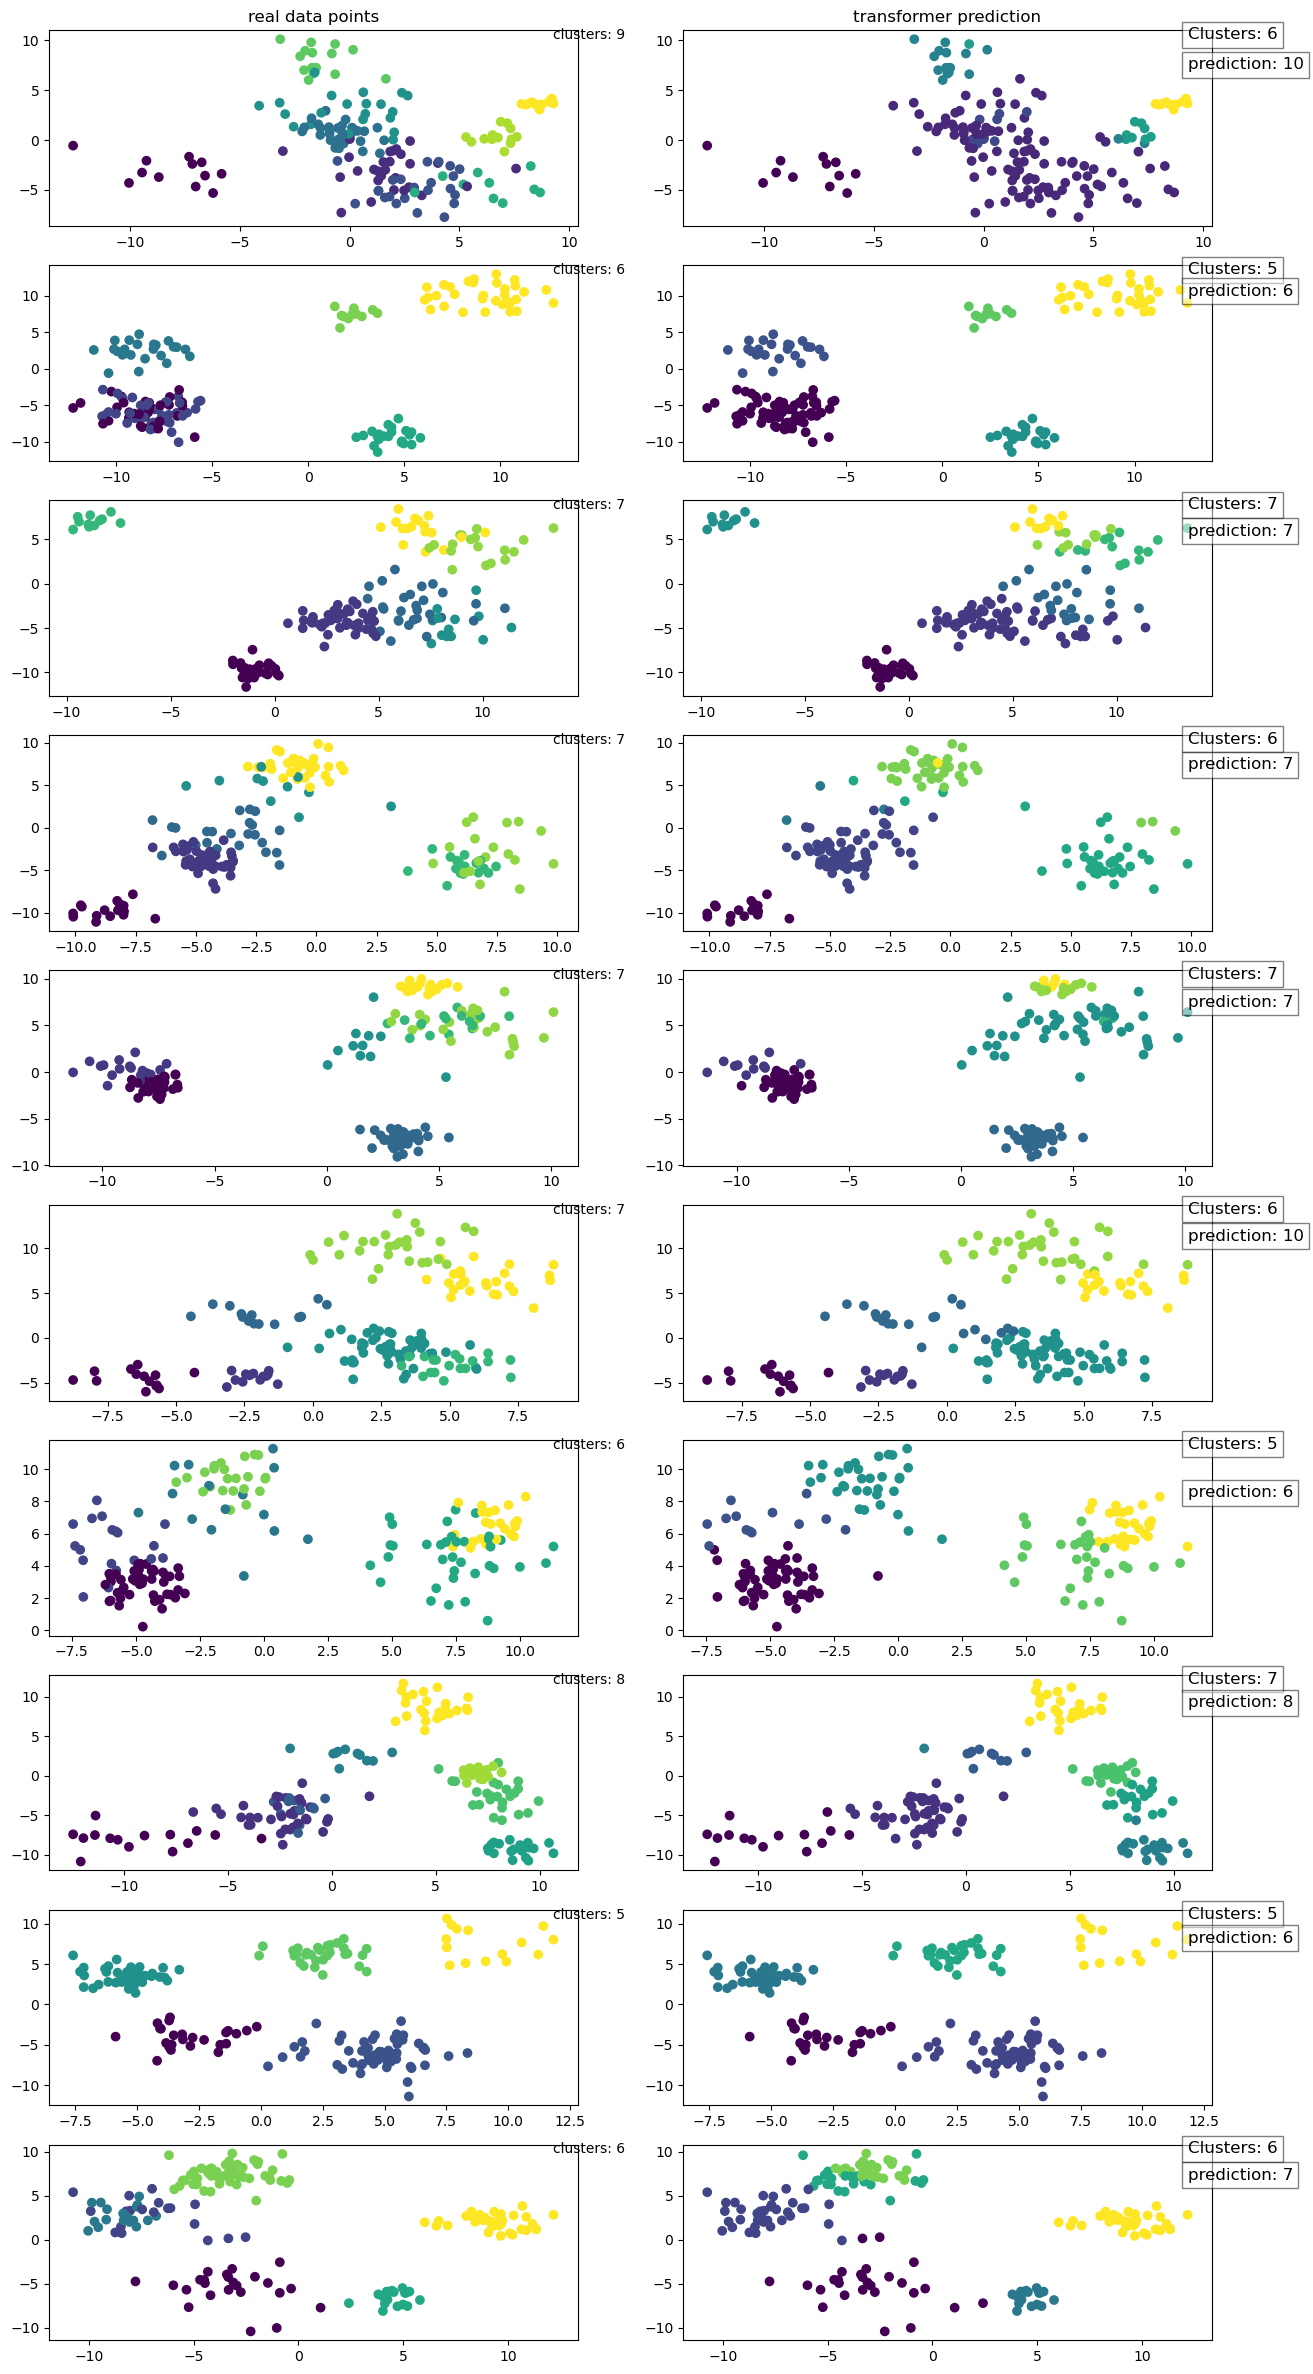

In [93]:
# # Set up grid for subplots
fig, axes = plt.subplots(temp_batch_size, 2, figsize=(15, 30)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    train_x_true = X_true[:, batch_index].unsqueeze(1)
    train_x = train_X[:, batch_index].unsqueeze(1)
    train_y = train_Y[:, batch_index] 
    batch = batch_classes[batch_index].unsqueeze(-1)
    axes[2 * batch_index].scatter(train_x_true[:, 0, 0].cpu().numpy() , train_x_true[:,0, 1].cpu().numpy() , c=train_y.cpu().numpy())
    x_max, y_max = train_x_true[:, 0, 0].cpu().max(), train_x_true[:, 0, 1].cpu().max()
    axes[2 * batch_index].text(x_max, y_max,f"clusters: {torch.unique(train_y).numel()}")

    num = 0
    logits,cluster_output = model(train_x, torch.full(batch.shape, num, dtype=torch.long, device=device))
    logits = logits.squeeze(1)
    cluster_output = cluster_output.squeeze(1)
    predictions = torch.argmax(logits, dim=1)
    predictions_cluster_count = torch.argmax(cluster_output, dim=1)
    axes[2 * batch_index +1].scatter(train_x_true[:,0, 0].cpu().numpy() , train_x_true[:,0, 1].cpu().numpy() , c=predictions.cpu().numpy())
    x_max, y_max = train_x_true[:, 0, 0].cpu().max(), train_x_true[:, 0, 1].cpu().max()
    axes[2 * batch_index + 1].text(x_max, y_max, f"Clusters: { torch.unique(predictions).numel()}",fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    axes[2 * batch_index + 1].text(x_max, y_max - 3, f"prediction: {predictions_cluster_count.item() + 1}",fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

axes[1].set_title(f"transformer prediction")
axes[0].set_title(f"real data points")
plt.show()

In [88]:
# %matplotlib inline
# temp_batch_size = 500
# seq_len = 500 
# train_X, train_Y, X_true, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len, num_features=2, num_classes=5, cluster_type='make_blobs')
# model.eval()
# print("") 

In [89]:
# accuracy_buckets_pfn  =utils.compute_accuracy_distribution(train_X, train_Y, batch_classes,model,model_type='transformer')
# accuracy_buckets_gmm = utils.compute_accuracy_distribution(X_true, train_Y, batch_classes,model_type='gmm')
# accuracy_buckets_kmeans = utils.compute_accuracy_distribution(X_true, train_Y, batch_classes,model,model_type='kmeans')

# print(accuracy_buckets_pfn) 
# print(accuracy_buckets_gmm) 
# print(accuracy_buckets_kmeans) 

In [90]:
# utils.plot_accuracy_metric(accuracy_buckets_pfn, 'pfn')
# utils.plot_accuracy_metric(accuracy_buckets_gmm, 'GMM')
# utils.plot_accuracy_metric(accuracy_buckets_kmeans, 'Kmeans')

In [9]:
%matplotlib inline
temp_batch_size = 500
seq_len = 500 
train_X, train_Y, X_true, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len, num_features=2, num_classes=10, cluster_type='make_blobs')
model.eval()
print("") 

In [10]:
logits,cluster_output = model(train_X, torch.full(batch_classes.shape, 0, dtype=torch.long, device=device))
predictions = torch.argmax(logits, dim=-1)


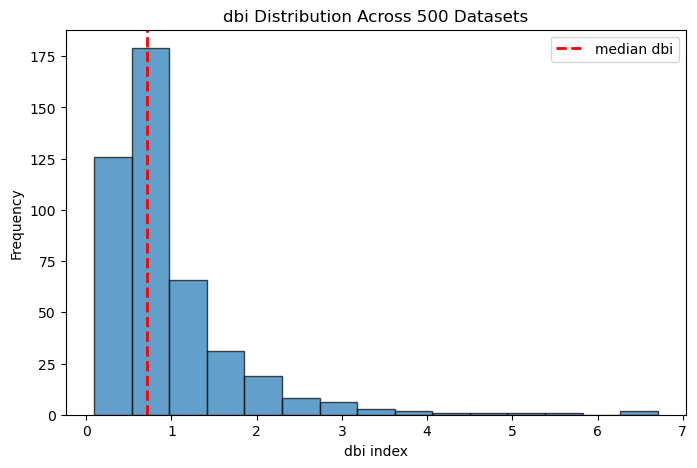

In [11]:
utils.compute_internal_metrics(train_X.cpu().numpy(), predictions.cpu().numpy(),'dbi') 
print('')

In [12]:
labels = utils.get_labels_bayesian_gmm(train_X.cpu().numpy())

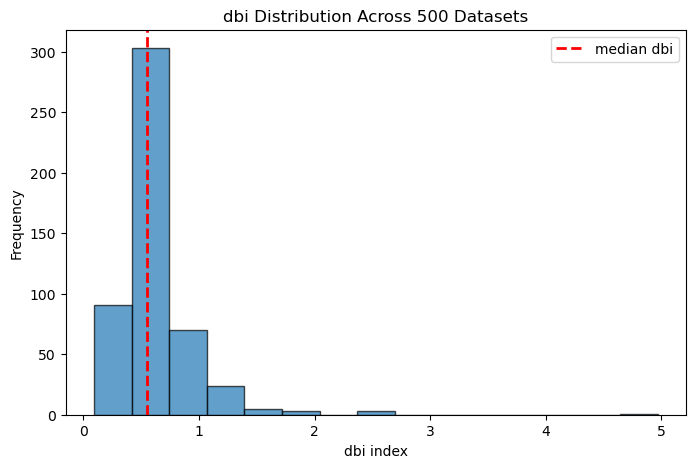

In [13]:
utils.compute_internal_metrics(train_X.cpu().numpy(), labels,'dbi') 
print()

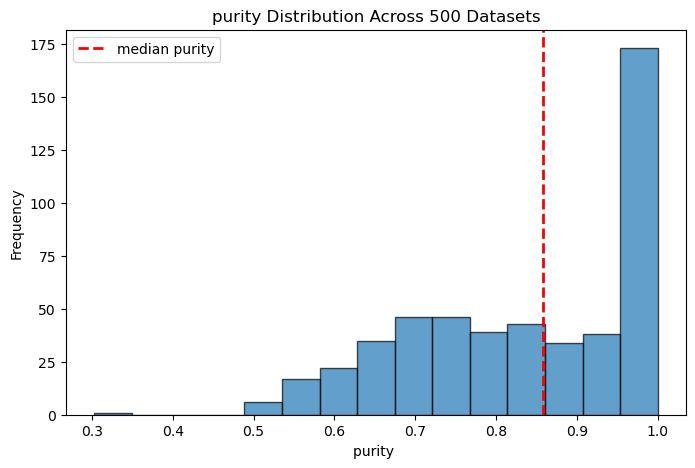

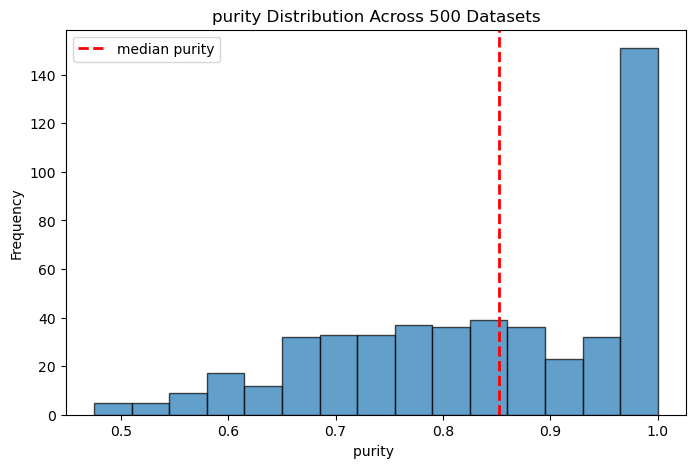

In [14]:
utils.compute_external_metrics(train_Y.cpu().numpy() ,predictions.cpu().numpy(), 'purity')
utils.compute_external_metrics(train_Y.cpu().numpy(), labels, 'purity')
print()

In [53]:
%matplotlib inline
temp_batch_size = 300
seq_len = 500 
train_X, train_Y, X_true, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len, num_features=2, num_classes=10, cluster_type='make_blobs')
model.eval()
print("") 
res = utils.correct_clusters_calculated(model, train_X, batch_classes)
print(res)


55.666666666666664


In [158]:
%matplotlib inline
temp_batch_size = 1
seq_len= 200
min_classes=5
train_X, train_Y, X_true, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len, num_features=2,min_classes=min_classes, num_classes=10, cluster_type='make_circles')
batch_classes = batch_classes.permute(1,0)
model.eval()
print("") 

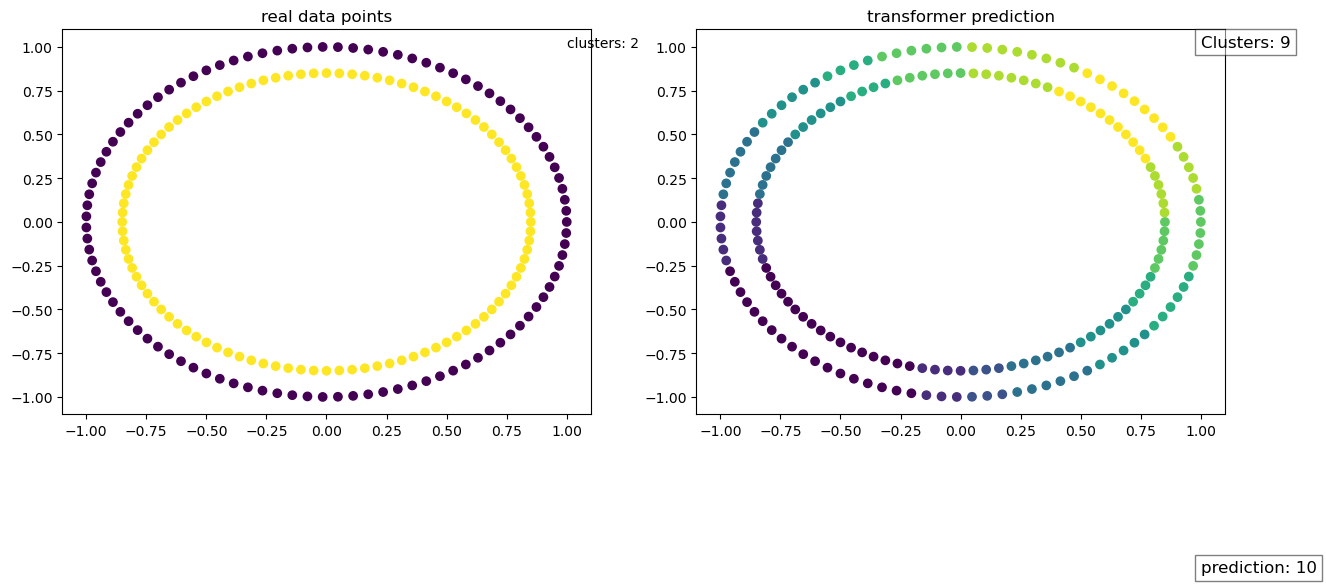

In [159]:
# # Set up grid for subplots
fig, axes = plt.subplots(temp_batch_size, 2, figsize=(15, 5)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    train_x_true = X_true[:, batch_index].unsqueeze(1)
    train_x = train_X[:, batch_index].unsqueeze(1)
    train_y = train_Y[:, batch_index] 
    batch = batch_classes[batch_index].unsqueeze(-1)
    axes[2 * batch_index].scatter(train_x_true[:, 0, 0].cpu().numpy() , train_x_true[:,0, 1].cpu().numpy() , c=train_y.cpu().numpy())
    x_max, y_max = train_x_true[:, 0, 0].cpu().max(), train_x_true[:, 0, 1].cpu().max()
    axes[2 * batch_index].text(x_max, y_max,f"clusters: {torch.unique(train_y).numel()}")
    num = 0
    logits,cluster_output = model(train_x, torch.full(batch.shape, num, dtype=torch.long, device=device))
    logits = logits.squeeze(1)
    cluster_output = cluster_output.squeeze(1)
    predictions = torch.argmax(logits, dim=1)
    predictions_cluster_count = torch.argmax(cluster_output, dim=1)
    axes[2 * batch_index +1].scatter(train_x_true[:,0, 0].cpu().numpy() , train_x_true[:,0, 1].cpu().numpy() , c=predictions.cpu().numpy())
    x_max, y_max = train_x_true[:, 0, 0].cpu().max(), train_x_true[:, 0, 1].cpu().max()
    axes[2 * batch_index + 1].text(x_max, y_max, f"Clusters: { torch.unique(predictions).numel()}",fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    axes[2 * batch_index + 1].text(x_max, y_max - 3, f"prediction: {predictions_cluster_count.item() + 1}",fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

axes[1].set_title(f"transformer prediction")
axes[0].set_title(f"real data points")
plt.show()

In [2]:
print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
device = torch.device("cuda")
d_model, nhead, nhid, nlayers = 256, 4, 512, 4
num_epochs = 500
lr = 0.001
num_outputs = 10
seq_len = 100
batch_size = 200
in_features = 2
noise = False
warm_up_epochs = 5
std_variation=True
model = transformer.Transformer(d_model, nhead, nhid, nlayers,in_features=in_features, buckets_size=num_outputs).to(device)
print(f"total params:{sum(p.numel() for p in model.parameters())}")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = utils.get_cosine_schedule_with_warmup(optimizer, warm_up_epochs, num_epochs)
model.criterion = criterion

Using device: Quadro P1000
total params:2114954


In [3]:
%matplotlib inline
model.load_state_dict(torch.load("C:\\Users\\prajb\\OneDrive\\Documents\\TU Delft CSE Masters Y2\\Thesis Projects\\PFN clustering\\models\\saved_model_make_blobs.pt", weights_only=True))
model.eval() 
print("")

In [4]:
print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
device = torch.device("cuda")
d_model, nhead, nhid, nlayers = 256, 4, 512, 4
num_epochs = 500
lr = 0.001
num_outputs = 10
seq_len = 100
batch_size = 200
in_features = 2
noise = False
warm_up_epochs = 5
std_variation=True
model2 = transformer.Transformer(d_model, nhead, nhid, nlayers,in_features=in_features, buckets_size=num_outputs).to(device)
print(f"total params:{sum(p.numel() for p in model2.parameters())}")
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=lr)
scheduler2 = utils.get_cosine_schedule_with_warmup(optimizer2, warm_up_epochs, num_epochs)
model.criterion = criterion

Using device: Quadro P1000
total params:2114954


In [5]:
%matplotlib inline
model2.load_state_dict(torch.load("C:\\Users\\prajb\\OneDrive\\Documents\\TU Delft CSE Masters Y2\\Thesis Projects\\PFN clustering\\models\\check_point_make_blobs.pt", weights_only=True))
model2.eval() 
print("")

In [6]:
%matplotlib inline
temp_batch_size = 10
train_X, train_Y, X_true, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len, num_features=2, num_classes=10, cluster_type='make_blobs')
batch_classes = batch_classes.permute(1,0)
model.eval()
print("") 

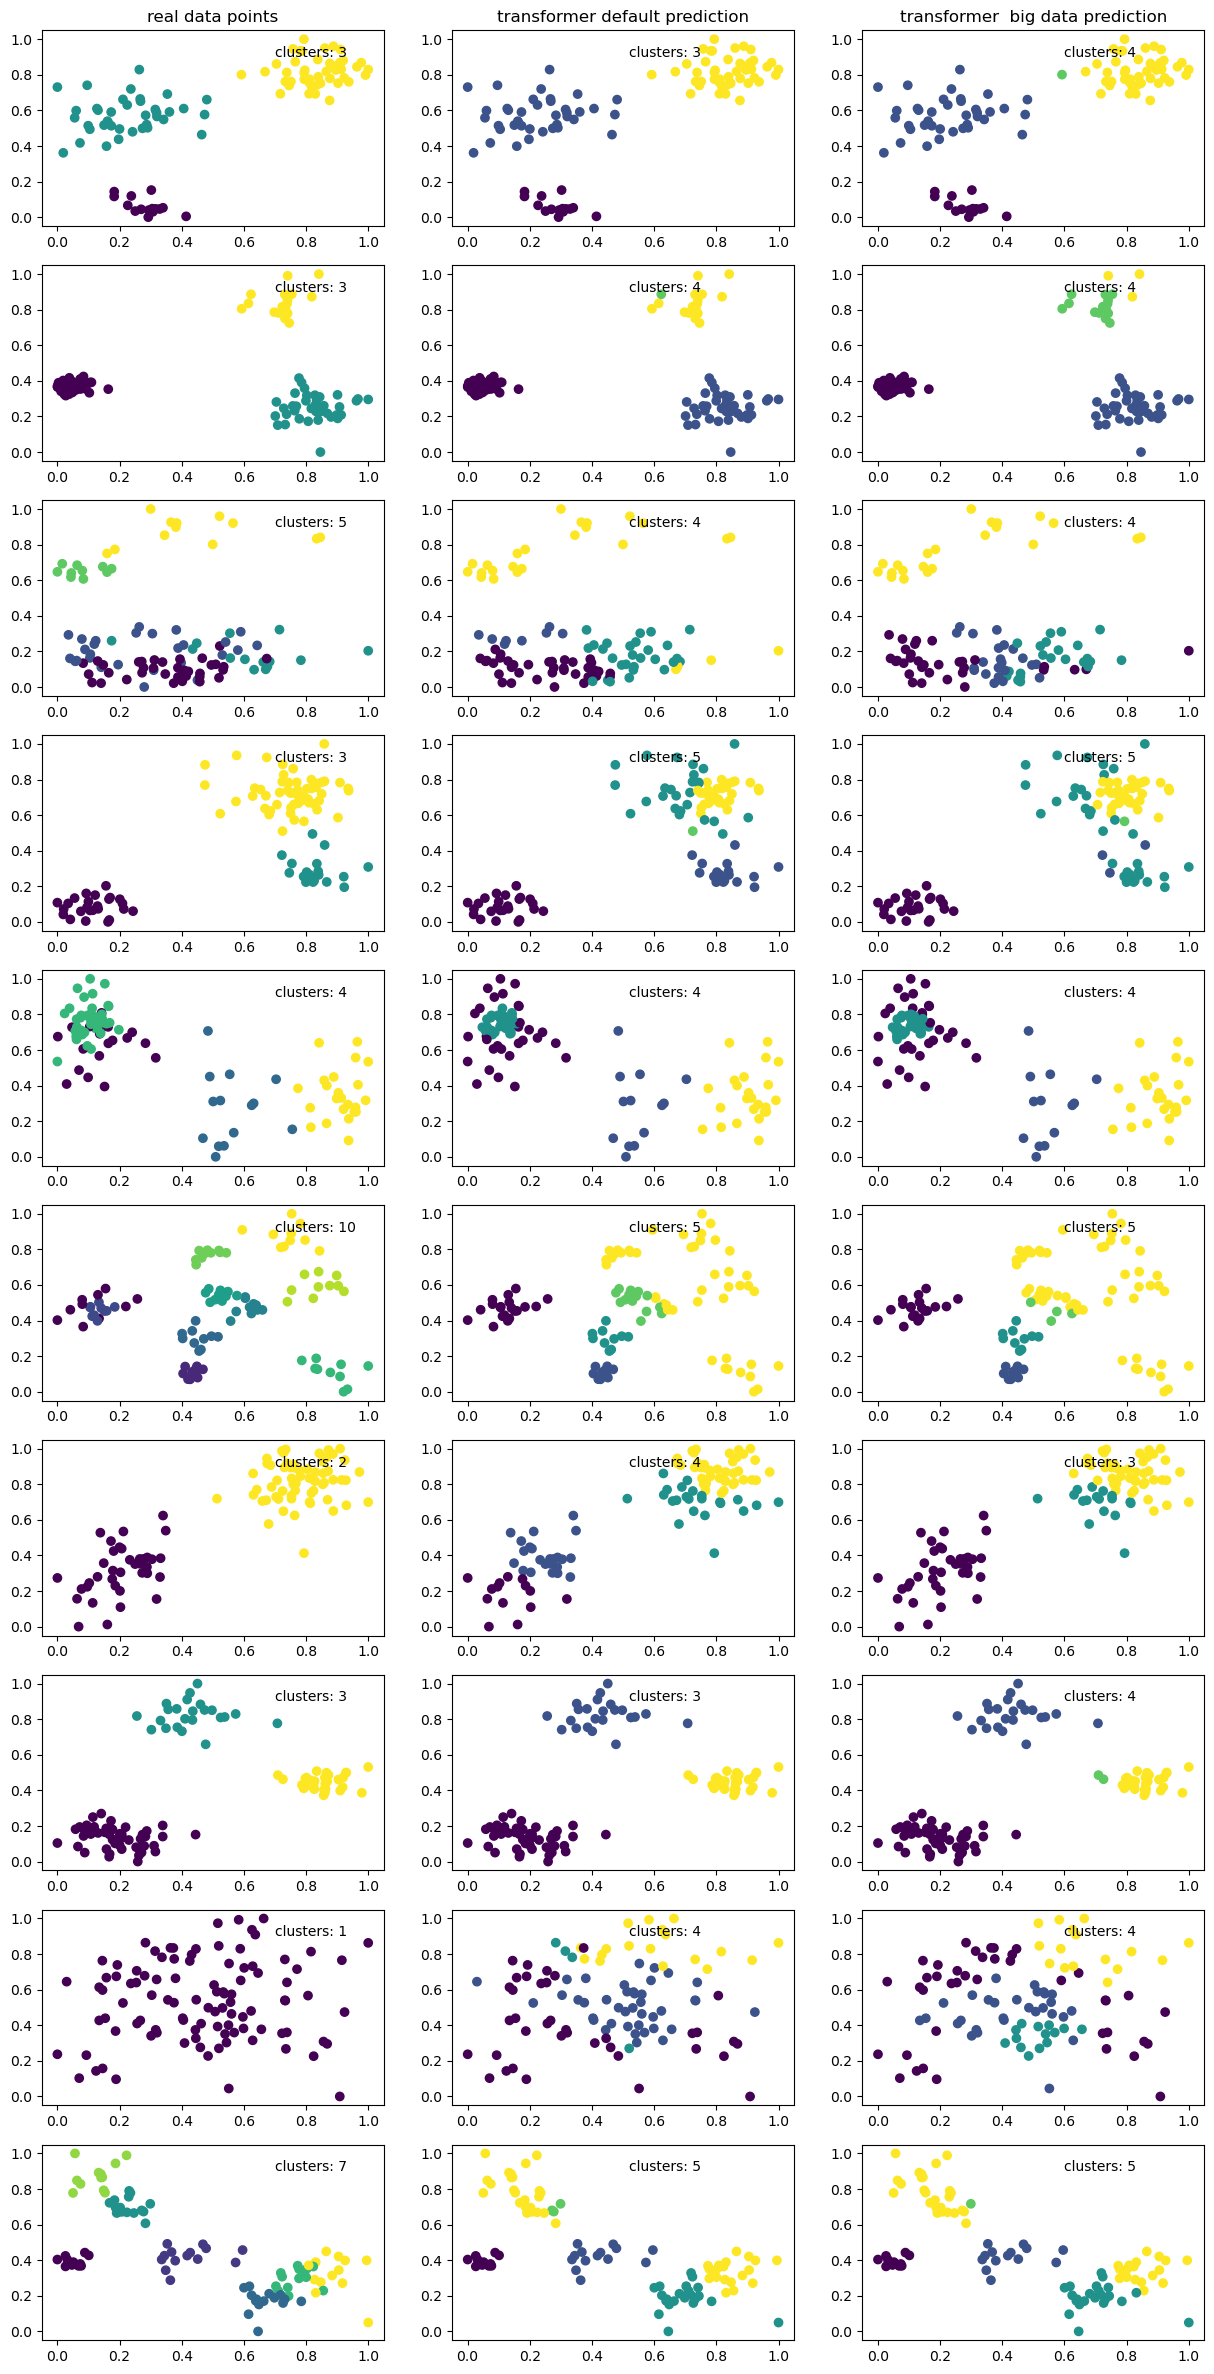

In [41]:
# # Set up grid for subplots
fig, axes = plt.subplots(temp_batch_size, 3, figsize=(15, 30)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    train_x = train_X[:, batch_index].unsqueeze(1)
    train_y = train_Y[:, batch_index] 
    axes[3 * batch_index].scatter(train_x[:, 0, 0].cpu().numpy() , train_x[:,0, 1].cpu().numpy() , c=train_y.cpu().numpy())
    axes[3 * batch_index].text(0.7, 0.9, f"clusters: {torch.unique(train_y).numel()}") 
    batch = batch_classes[batch_index].unsqueeze(-1)
    #logits,cluster_output = model(train_x, batch)
    
    num1= torch.full(batch.shape, 5, dtype=torch.long, device=device)
    logits, cluster_output= model(train_x,num1)
    logits = logits.squeeze(1)
    cluster_output = cluster_output.squeeze(1)
    predictions = torch.argmax(logits, dim=1)
    predictions_cluster_count = torch.argmax(cluster_output, dim=1)
    axes[3 * batch_index +1].scatter(train_x[:,0, 0].cpu().numpy() , train_x[:,0, 1].cpu().numpy() , c=predictions.cpu().numpy())
    #axes[3 * batch_index + 1].text(0.6, 0.9, f"clusters:{predictions_cluster_count.cpu().item() + 1}") 
    axes[3 * batch_index + 2].text(-0.8, 0.9, f"clusters: {torch.unique(predictions).numel()}") 

    num2= torch.full(batch.shape, 5, dtype=torch.long, device=device)
    logits, cluster_output= model2(train_x,num2)
    logits = logits.squeeze(1)
    cluster_output = cluster_output.squeeze(1)
    predictions = torch.argmax(logits, dim=1)
    predictions_cluster_count = torch.argmax(cluster_output, dim=1)
    axes[3 * batch_index +2].scatter(train_x[:,0, 0].cpu().numpy() , train_x[:,0, 1].cpu().numpy() , c=predictions.cpu().numpy())
    #axes[3 * batch_index + 2].text(0.6, 0.9, f"clusters:{predictions_cluster_count.cpu().item() + 1}") 
    axes[3 * batch_index + 2].text(0.6, 0.9, f"clusters: { torch.unique(predictions).numel() }") 

axes[1].set_title(f"transformer default prediction")
axes[0].set_title(f"real data points")
axes[2].set_title(f"transformer  big data prediction")
plt.show()

In [7]:
temp_batch_size = 500
seq_len = 500 
train_X, train_Y, X_true, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len, num_features=2, num_classes=10, cluster_type='make_blobs')
print("") 



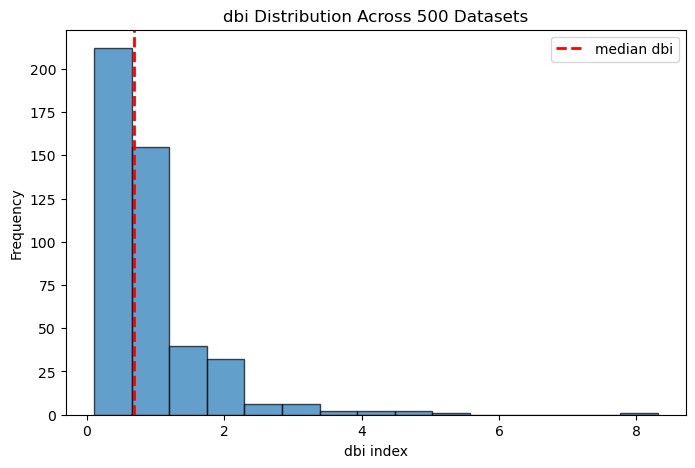

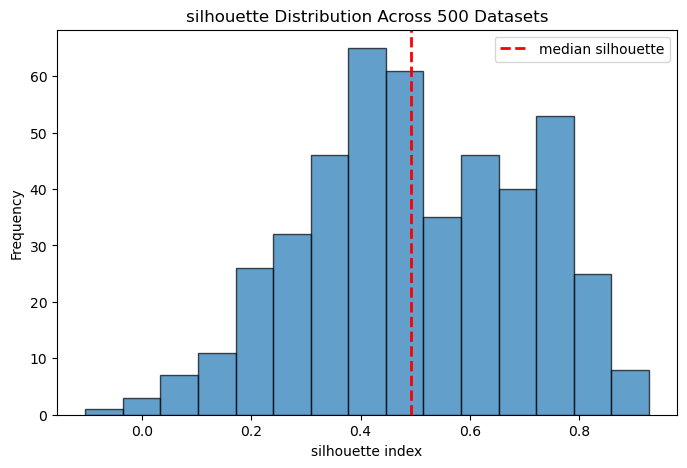

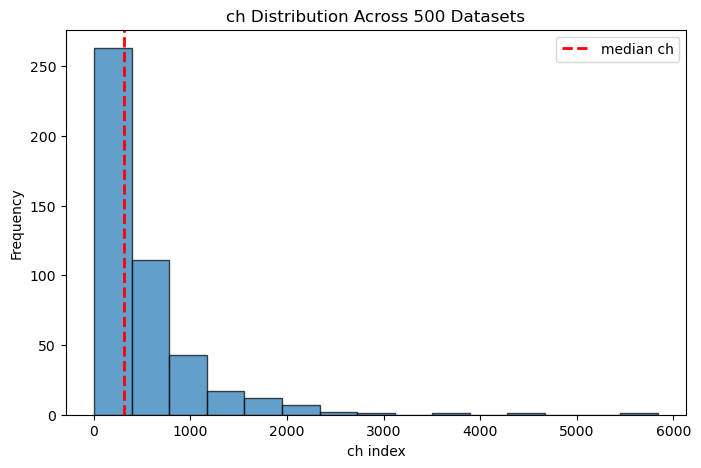

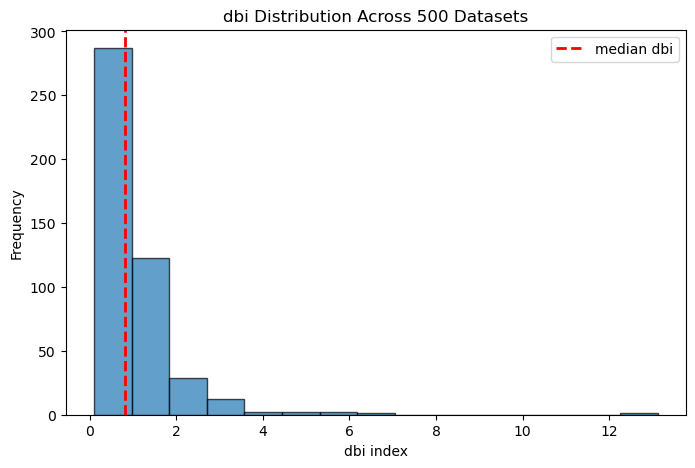

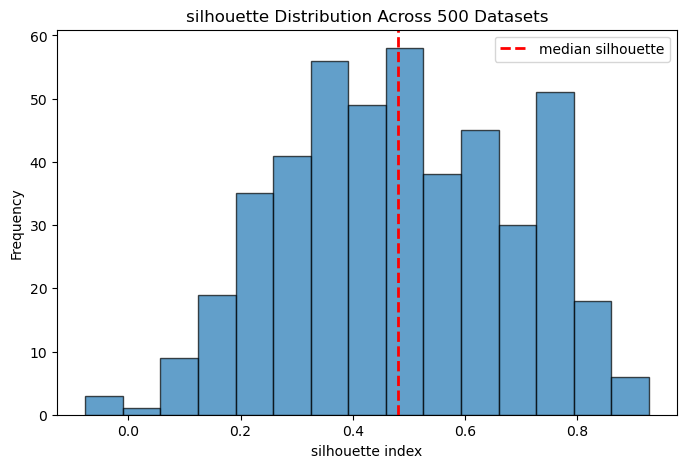

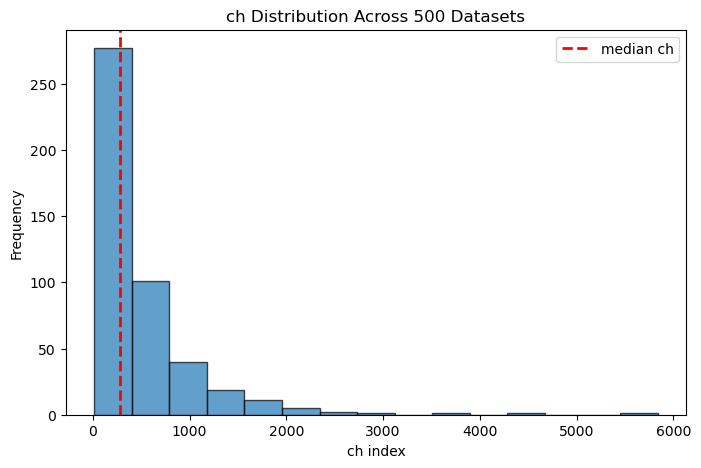

In [8]:
%matplotlib inline
logits,cluster_output = model(train_X, torch.full(batch_classes.shape, 0, dtype=torch.long, device=device))
predictions = torch.argmax(logits, dim=-1)

utils.compute_internal_metrics(train_X.cpu().numpy(), predictions.cpu().numpy(),'dbi') 
utils.compute_internal_metrics(train_X.cpu().numpy(), predictions.cpu().numpy(),'silhouette') 
utils.compute_internal_metrics(train_X.cpu().numpy(), predictions.cpu().numpy(),'ch') 
print('')

logits,cluster_output = model2(train_X, torch.full(batch_classes.shape, 0, dtype=torch.long, device=device))
predictions = torch.argmax(logits, dim=-1)


utils.compute_internal_metrics(train_X.cpu().numpy(), predictions.cpu().numpy(),'dbi') 
utils.compute_internal_metrics(train_X.cpu().numpy(), predictions.cpu().numpy(),'silhouette') 
utils.compute_internal_metrics(train_X.cpu().numpy(), predictions.cpu().numpy(),'ch') 
print('')

In [9]:
temp_batch_size = 100
seq_len = 500 
train_X, train_Y, X_true, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len, num_features=2, num_classes=5, cluster_type='make_blobs')
print("") 


In [10]:
accuracy_buckets_pfn  =utils.compute_accuracy_distribution(train_X, train_Y, batch_classes,model,model_type='transformer')
accuracy_buckets_pfn2  =utils.compute_accuracy_distribution(train_X, train_Y, batch_classes,model2,model_type='transformer')

print(accuracy_buckets_pfn) 
print(accuracy_buckets_pfn2) 

[ 0.  0.  0.  0.  0.  0. 11.  9. 18. 14. 48.]
[ 0.  0.  0.  0.  0.  4. 12.  9. 16. 12. 47.]


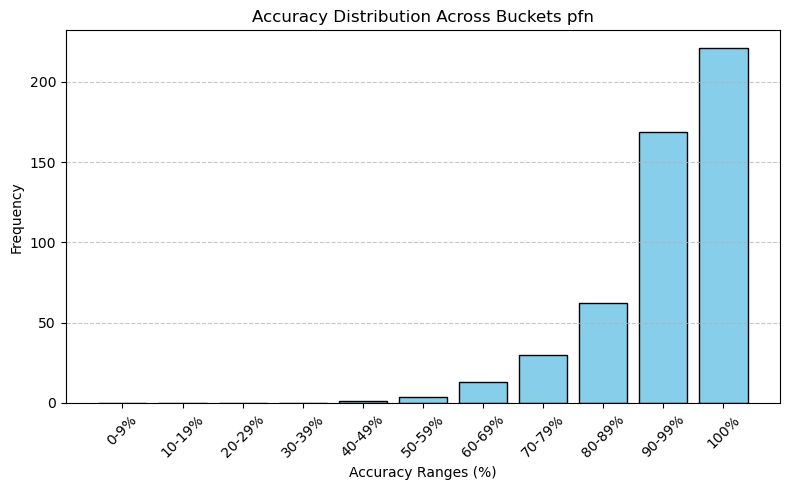

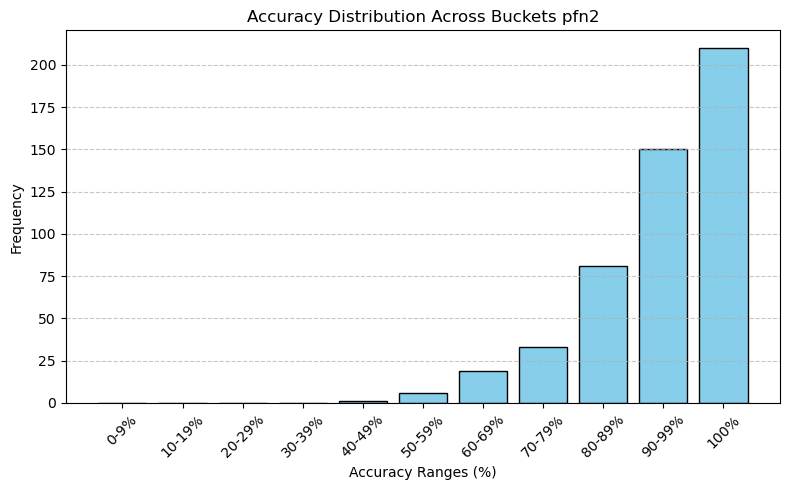

In [8]:
utils.plot_accuracy_metric(accuracy_buckets_pfn, 'pfn')
utils.plot_accuracy_metric(accuracy_buckets_pfn2, 'pfn2')
